# Global Terrorism Database EDA



This project was originally created as part of my portfolio when I first started my data analytics journey. I recently revisited it with the goal of improving both its functionality and presentation, while incorporating new things I learned in this class.The questions originate from [Stratascratch](https://platform.stratascratch.com/data-projects/terrorism-hotspots).

[The Global Terrorism Database (GTD)](https://www.start.umd.edu/gtd/contact/download) has made available data on terrorist events around the world from 1970 through 2021.
The original, comprehensive dataset comprises 135 columns and over 200,000 rows. Given the file size limitations of this project, however, the data set has been pre-processed, resulting in a smaller, more manageable data set that now contains only nine columns and begins in 1990 instead of 1970.

The aim of this notebook is to answer the following questions:

1. How has the number of terrorist activities changed over the years? Are there certain regions where this trend is different from the global averages?

2. Is the number of incidents and the number of casualties correlated? Any irregularities or outliers?

3. What are the most common methods of attacks? Does it differ in various regions or in time?

4. Plot the locations of attacks on a map to visualize their regional spread.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

%matplotlib inline

In [2]:
df1 = pd.read_excel("1995-2020.xlsx")
df2 = pd.read_excel("2021.xlsx")

df1 contains data from 1990 to 2020; df2 contains data for the first 6 months of 2021.

In [3]:
print(df1.columns.tolist())

['eventid', 'iyear', 'country_txt', 'region_txt', 'latitude', 'longitude', 'attacktype1_txt', 'gname', 'nkill']


In [4]:
print(df2.columns.tolist())

['eventid', 'iyear', 'country_txt', 'region_txt', 'latitude', 'longitude', 'attacktype1_txt', 'gname', 'nkill']


It's relatively easy to do a quick visual inspection to make sure the 2 dataframes have the exact same columns before combining them when there are only 9 columns, but imagine if they were raw, containing 135 columns...then we probably want to do this:

In [5]:
df1.columns.tolist() == df2.columns.tolist()

True

In [6]:
#vertically stack (concat) two dataframes
df = pd.concat([df1,df2],ignore_index=True)
df

,eventid,iyear,country_txt,region_txt,latitude,longitude,attacktype1_txt,gname,nkill
0,199001000001,1990,Lebanon,Middle East & North Africa,33.888523,35.503513,Hostage Taking (Kidnapping),Unknown,0.0
1,199001010001,1990,India,South Asia,34.083740,74.789902,Bombing/Explosion,Unknown,0.0
2,199001010002,1990,India,South Asia,34.083740,74.789902,Bombing/Explosion,Unknown,0.0
3,199001010003,1990,India,South Asia,34.083740,74.789902,Bombing/Explosion,Unknown,0.0
4,199001010004,1990,Bolivia,South America,-17.382789,-66.166439,Bombing/Explosion,Alejo Calatayu,0.0
...,...,...,...,...,...,...,...,...,...
173592,202106300023,2021,Afghanistan,South Asia,35.054772,69.196838,Bombing/Explosion,Unknown,0.0
173593,202106300029,2021,Myanmar,Southeast Asia,23.986739,97.897143,Hostage Taking (Kidnapping),Unknown,1.0
173594,202106300030,2021,Nigeria,Sub-Saharan Africa,11.572869,13.014035,Hostage Taking (Kidnapping),Boko Haram,0.0
173595,202106300038,2021,Colombia,South America,3.104189,-76.333069,Bombing/Explosion,Revolutionary Armed Forces of Colombia (FARC) ...,0.0


In [7]:
df.dtypes

eventid              int64
iyear                int64
country_txt         object
region_txt          object
latitude           float64
longitude          float64
attacktype1_txt     object
gname               object
nkill              float64
dtype: object

Checking the missing data:
Since this is a fairly large dataset, we can use the method below to filter out some columns that aren't very useful for analysis due to too much missing data.
See https://www.start.umd.edu/gtd/downloads/Codebook.pdf for explanations of column header names.

In [8]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{}-{}%'.format(col,pct_missing*100.00)) 

eventid-0.0%
iyear-0.0%
country_txt-0.0%
region_txt-0.0%
latitude-1.4579745041676988%
longitude-1.4585505509887844%
attacktype1_txt-0.0%
gname-0.0%
nkill-4.1878603892924415%


The results aren't too bad (which is exactly why these 9 columns were chosen out of 135 columns in the original dataset). It's generally okay to have less than 5% missing data.

The following table summarizes the variable names of our subset data:

| Column Name | Meaning | 
| :- | :- |
| eventid | GTD ID |
| iyear | Year |
| country_txt | Country |
| region_txt | Region |
| latitude | Latitude of the city in which the event occurred |
| longitude | Longitude of the city in which the event occurred |
| attacktype1_txt | General method of attack |
| gname | Name of the group that carried out the attack |
| nkill | Total Number of Fatalities |

We can rename some of the columns for readability.

In [9]:
df = df.rename(columns={"iyear":"year","country_txt":"country","region_txt":"region","attacktype1_txt":"attack_type",
                        "gname":"perpetrator","nkill":"fatalities"})

Now we start answering the questions. 

### 1. How has the number of terrorist activities changed over the years? Are there certain regions where this trend is different from the global averages?

In [10]:
# select the columns needed to answer question #1
df_1 = df[["eventid","year","country","region","attack_type"]]

<AxesSubplot:title={'center':'Number of attacks by year, 1990-2021'}, xlabel='Year', ylabel='Number of attacks'>

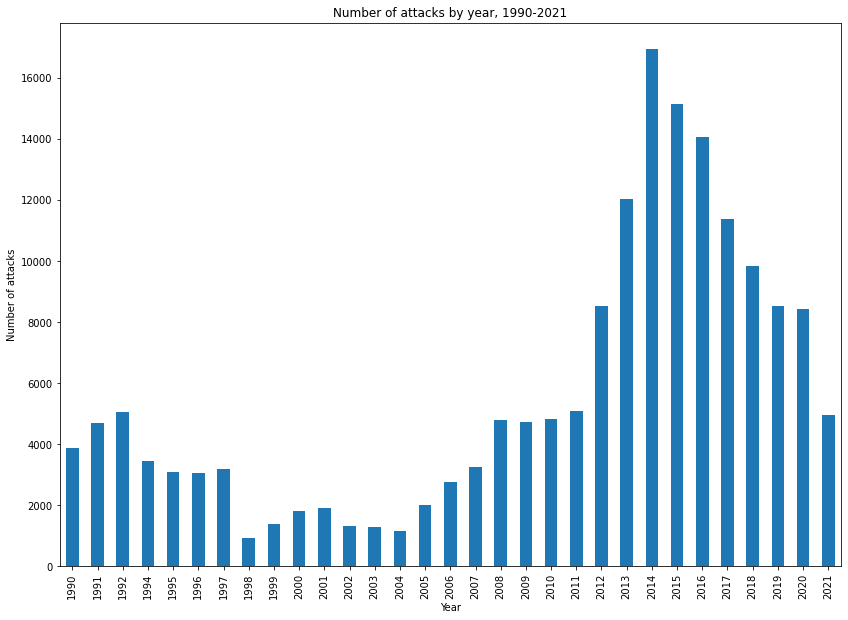

In [11]:
# create a bar chart to show the number of attacks for each year.
bars = df_1.groupby("year")["eventid"].count()
bars.plot.bar(xlabel="Year",ylabel="Number of attacks",title="Number of attacks by year, 1990-2021",figsize=(14,10))

In [12]:
#create a pivot table to later visualize trends in terrorist activities across different regions over the years
trend = df_1.pivot_table("eventid",index="year",columns="region",aggfunc="count").fillna(0)
trend.head()

region,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe
year,,,,,,,,,,,,
1990,18.0,316.0,0.0,99.0,58.0,494.0,37.0,1076.0,600.0,348.0,450.0,390.0
1991,10.0,729.0,7.0,29.0,84.0,612.0,41.0,1322.0,677.0,206.0,271.0,697.0
1992,17.0,212.0,77.0,74.0,91.0,1192.0,41.0,1204.0,545.0,279.0,570.0,769.0
1994,14.0,180.0,65.0,34.0,95.0,1051.0,101.0,373.0,376.0,151.0,432.0,584.0
1995,18.0,168.0,55.0,38.0,68.0,590.0,94.0,255.0,1051.0,168.0,239.0,337.0


In [13]:
# top 10 countries with the most attacks
by_country = df_1.groupby(["country","region"])["eventid"].count().nlargest(10,keep="all").reset_index(name="count")
by_country

,country,region,count
0,Iraq,Middle East & North Africa,28032
1,Afghanistan,South Asia,20347
2,Pakistan,South Asia,15441
3,India,South Asia,12912
4,Philippines,Southeast Asia,7333
5,Yemen,Middle East & North Africa,6317
6,Nigeria,Sub-Saharan Africa,5991
7,Colombia,South America,5621
8,Somalia,Sub-Saharan Africa,5424
9,Thailand,Southeast Asia,4128


In [14]:
# calculate the global average of attacks across all regions for each year 
trend["Global_average"] = trend.mean(axis=1)
trend.tail()

region,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe,Global_average
year,,,,,,,,,,,,,
2017,13.0,4.0,8.0,7.0,112.0,4183.0,105.0,179.0,3432.0,1024.0,2000.0,297.0,947.000000
2018,21.0,15.0,7.0,6.0,72.0,2740.0,110.0,303.0,3287.0,875.0,2212.0,205.0,821.083333
2019,5.0,15.0,3.0,18.0,44.0,2175.0,108.0,276.0,3039.0,715.0,1944.0,195.0,711.416667
2020,21.0,13.0,6.0,21.0,60.0,1802.0,130.0,267.0,3418.0,419.0,1997.0,284.0,703.166667
2021,1.0,2.0,0.0,5.0,16.0,1262.0,59.0,147.0,1853.0,373.0,1137.0,105.0,413.333333


<AxesSubplot:title={'center':'Number of terrorist attacks per region,1990-2021'}, xlabel='year', ylabel='Number of terrorist attacks'>

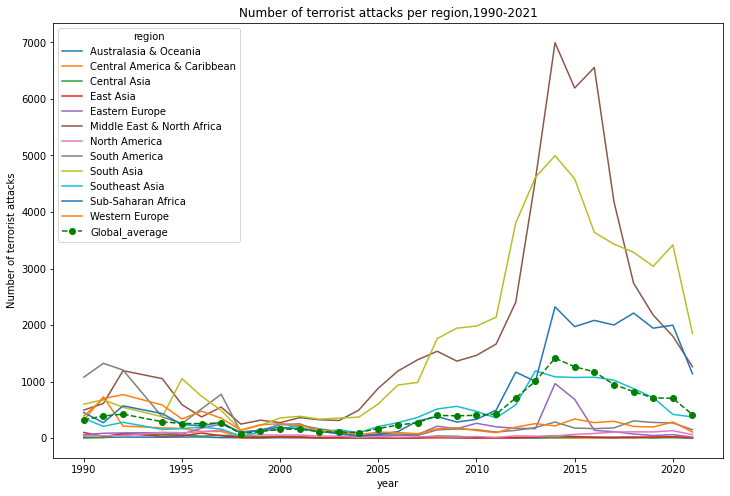

In [15]:
trend.plot(xlabel="year",ylabel="Number of terrorist attacks",
           title="Number of terrorist attacks per region,1990-2021",
           style=['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'go--'],figsize=(12,8))

It looks like there are a few regions of the world that have very few attacks compared to other regions and the global average. Let's identify them.

In [16]:
# Are there any regions never surpass the numbers of attacks than the global average?
always_lower_than_global_avg = trend.columns[:-1][~(trend.iloc[:, :-1] > trend["Global_average"]\
                                                    .values.reshape(-1, 1)).any(axis=0)]
always_lower_than_global_avg = list(always_lower_than_global_avg)
always_lower_than_global_avg

['Australasia & Oceania', 'Central Asia', 'East Asia', 'North America']

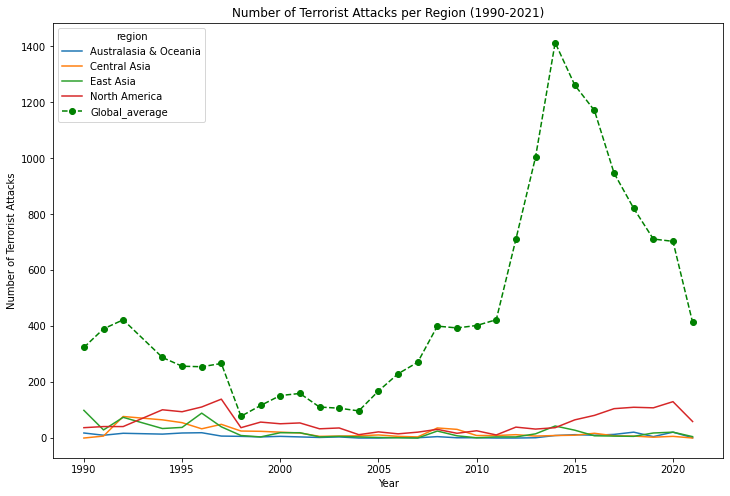

In [17]:
trend[['Australasia & Oceania', 'Central Asia', 'East Asia', 'North America', 'Global_average']].plot(
    xlabel="Year",
    ylabel="Number of Terrorist Attacks",
    title="Number of Terrorist Attacks per Region (1990-2021)",
    style=['-', '-', '-','-','go--'],
    figsize=(12, 8)
)
plt.show()

What about regions that have a significantly higher number of attacks compared to other regions and the global average? Let's identify them.

In [18]:
# Are there any regions always surpass the numbers of attacks than the global average?
always_higher_than_global_avg = trend.columns[:-1][~(trend.iloc[:, :-1] < trend["Global_average"]\
                                                     .values.reshape(-1, 1)).any(axis=0)]
always_higher_than_global_avg = list(always_higher_than_global_avg)
always_higher_than_global_avg

['Middle East & North Africa', 'South Asia']

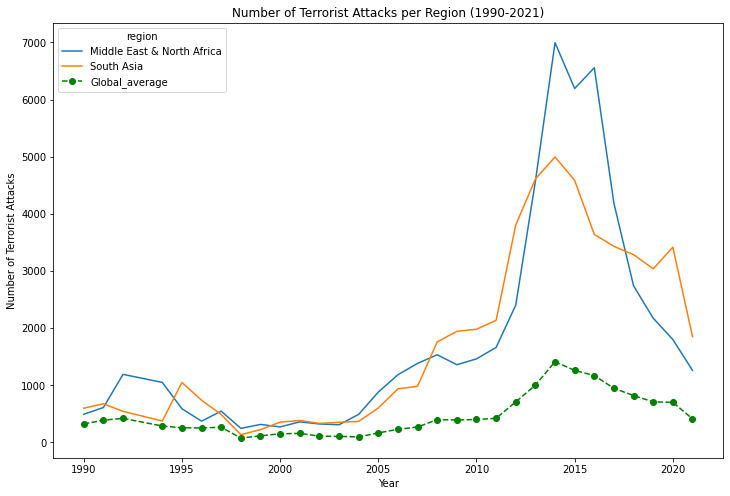

In [19]:
trend[['Middle East & North Africa', 'South Asia', 'Global_average']].plot(
    xlabel="Year",
    ylabel="Number of Terrorist Attacks",
    title="Number of Terrorist Attacks per Region (1990-2021)",
    style=['-', '-','go--'],
    figsize=(12, 8)
)
plt.show()

#### Conclusion:
Since the 1990s, there has been a notable increase in attacks globally, with a slight decline between 1998 and 2004. Attacks in South Asia, the Middle East & North Africa began to increase sharply around 2003 and peaked in 2014. On the other hand, the number of attacks in East Asia, Central Asia, Australasia and Oceania, and North America has consistently been lower than the global average.

### 2. Is the number of incidents and the number of casualties correlated? Any irregularities or outliers?

In [20]:
df_2 = df.fillna(0)
corr = df_2.groupby(["year"]).agg({'fatalities' : 'sum', 'eventid' : 'count'})
corr = corr.rename(columns={"eventid":"attack_count"})
corr

,fatalities,attack_count
year,,
1990,7036.0,3886
1991,8454.0,4685
1992,9745.0,5071
1994,7690.0,3456
1995,6103.0,3081
1996,6966.0,3058
1997,10906.0,3198
1998,4688.0,934
1999,3394.0,1396


In [21]:
#calculate the correlation matrix between the total number of fatalities and the count of events for each year.
matrix = corr.corr()
matrix

,fatalities,attack_count
fatalities,1.000000,0.966377
attack_count,0.966377,1.000000


The correlation matrix indicates a strong positive correlation between the total number of fatalities and the count of events.

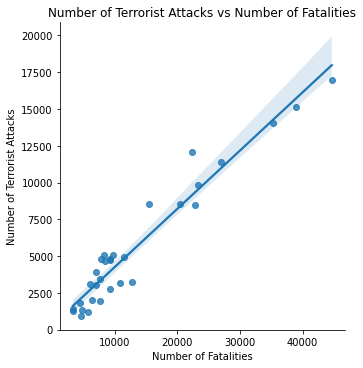

In [22]:
#visualize the correlation
ax = sns.lmplot(x="fatalities", y="attack_count",data=corr,height=5)
ax.set(xlabel="Number of Fatalities",
       ylabel="Number of Terrorist Attacks",
       title="Number of Terrorist Attacks vs Number of Fatalities")

In [23]:
#correlation between fatalities and events for each region, sorted in descending order
corr_region = df_2.groupby(["region","year"]).agg({'fatalities' : 'sum', 'eventid' : 'count'})
corr_region=corr_region.groupby("region").apply(lambda x: x.corr()).unstack().iloc[:,1].sort_values(ascending=False).reset_index(name="correlation")
corr_region

,region,correlation
0,Central America & Caribbean,0.977320
1,Middle East & North Africa,0.958975
2,South America,0.942664
3,Sub-Saharan Africa,0.922591
4,South Asia,0.902981
5,Eastern Europe,0.842148
6,Central Asia,0.822683
7,Southeast Asia,0.793708
8,Western Europe,0.545699
9,Australasia & Oceania,0.233732


Let's try to visualize how the regional correlation varies.

In [24]:
corr_2 = df.groupby(["year","region"]).agg({'fatalities' : 'sum', 'eventid' : 'count'})
corr_2.reset_index(inplace=True)
corr_2 = corr_2.rename(columns={"eventid":"attack_count"})
corr_2

,year,region,fatalities,attack_count
0,1990,Australasia & Oceania,12.0,18
1,1990,Central America & Caribbean,406.0,316
2,1990,East Asia,4.0,99
3,1990,Eastern Europe,59.0,58
4,1990,Middle East & North Africa,778.0,494
...,...,...,...,...
359,2021,South America,108.0,147
360,2021,South Asia,4671.0,1853
361,2021,Southeast Asia,374.0,373
362,2021,Sub-Saharan Africa,4836.0,1137


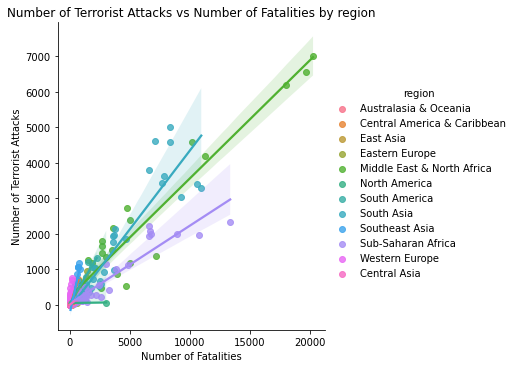

In [25]:
ax = sns.lmplot(x="fatalities", y="attack_count",hue="region",data=corr_2,height=5)

ax.set(xlabel="Number of Fatalities",
       ylabel="Number of Terrorist Attacks",
       title="Number of Terrorist Attacks vs Number of Fatalities by region")

The above graph is overcrowed. To better illustrate the correlation of each region, we can divide it into several subplots.

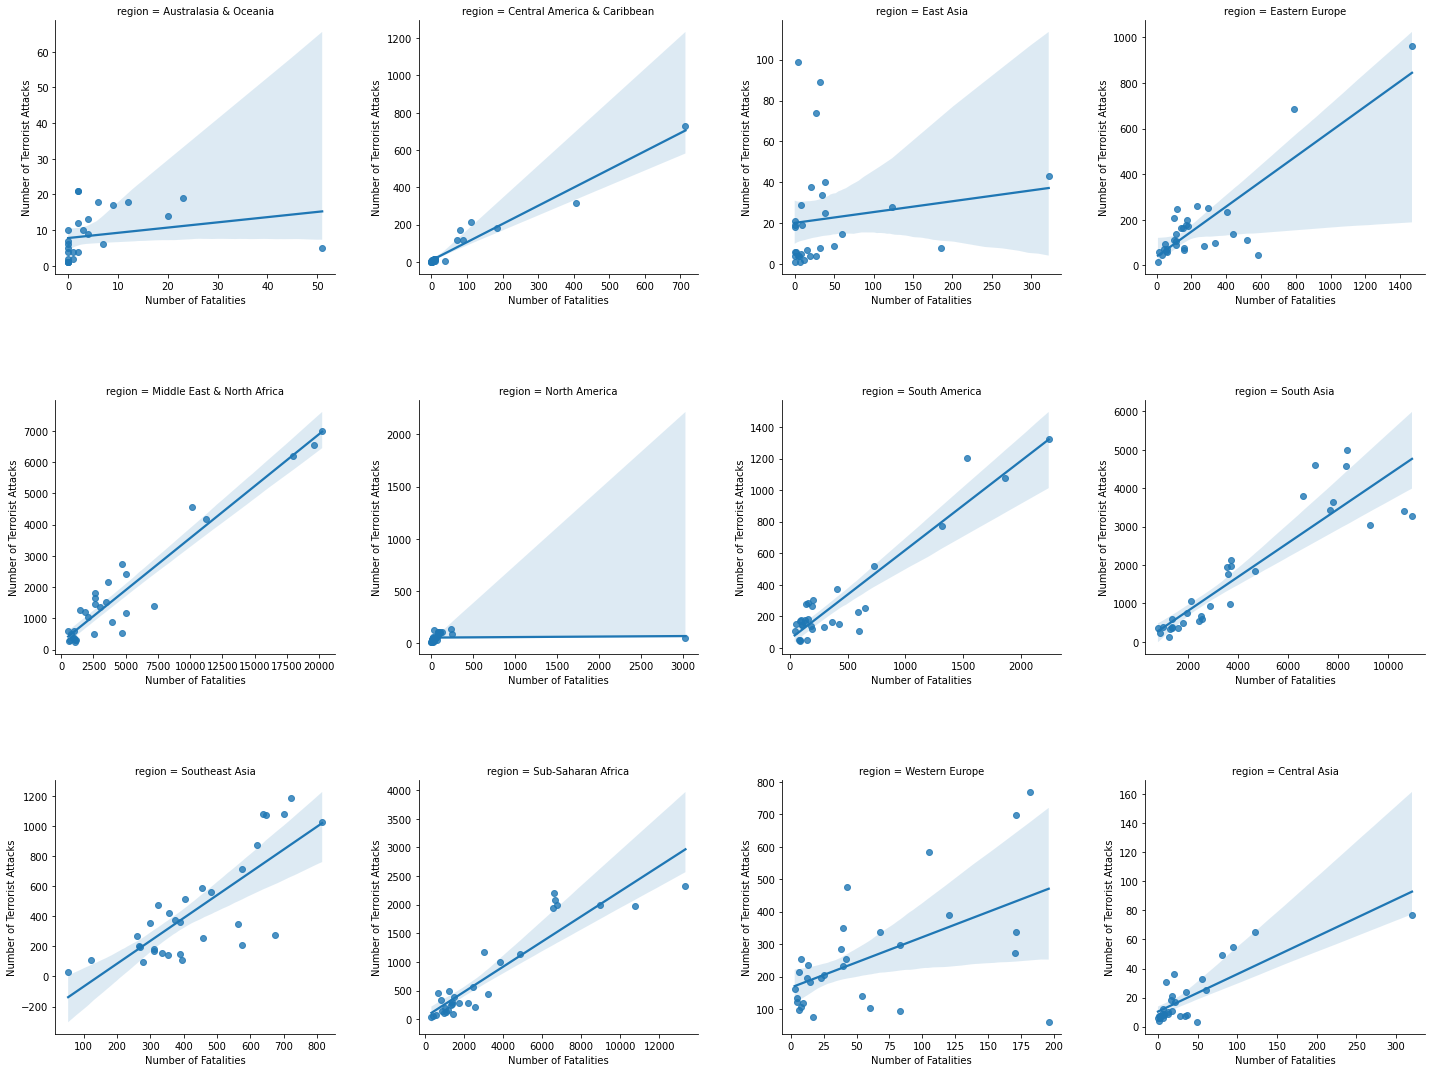

In [26]:
ax=sns.lmplot(
    data=corr_2,x="fatalities", y="attack_count",
    col="region",
    col_wrap=4,height=5,
    facet_kws=dict(sharex=False, sharey=False)
)

plt.subplots_adjust(hspace=0.5,wspace=0.3)

ax.set(xlabel="Number of Fatalities",
       ylabel="Number of Terrorist Attacks")
    

Apparently, there is a very noticeable outlier that causes North America to have a very week correlation. 

In [27]:
# top 5 years with the largest number of fatalities in North America
north_america = df_2[(df_2["region"]=="North America")].groupby("year").agg({'fatalities' : 'sum', 'eventid' : 'count'})
north_america.rename(columns={"eventid": "attack_count"}, inplace=True)  
north_america.nlargest(5, "fatalities", keep="first").reset_index()

,year,fatalities,attack_count
0,2001,3027.0,54
1,1995,240.0,94
2,1997,231.0,139
3,2017,131.0,105
4,1994,98.0,101


The data point for the year 2001 stands out due to a significant increase in the number of fatalities, which coincides with a major event in that year.

#### Conclusion:
Overall, a territory's death toll and the number of attacks that occurred there have a strong correlation. North America is the only extreme outlier with a standard correlation coefficient of less than 0.1, with Australasia & Oceania and East Asia being the other outliers. 
<br>(*In fact, in my original analysis, which includes data from 1970 onward, shows that North America has a negative correlation coefficient of -0.2. This shows that it's important to consider the time period of the data when interpreting correlation values, as trends can change over time.*)


### 3.What are the most common methods of attacks? Does it differ in various regions or in time?

In [28]:
df_3 = df

In [29]:
#most popular methods of attacks, by year
most_popular_type_by_year = df.groupby(["year", "attack_type"]).size().groupby(level=0).idxmax().reset_index(name='attack_type')
most_popular_type_by_year[['year', 'attack_type']] = pd.DataFrame(most_popular_type_by_year['attack_type'].tolist(),\
                                                                  index=most_popular_type_by_year.index)
most_popular_type_by_year['attack_count'] = df.groupby(["year", "attack_type"]).size().groupby(level=0).max().values
most_popular_type_by_year

,year,attack_type,attack_count
0,1990,Bombing/Explosion,1731
1,1991,Bombing/Explosion,1988
2,1992,Bombing/Explosion,1738
3,1994,Bombing/Explosion,1153
4,1995,Bombing/Explosion,791
5,1996,Bombing/Explosion,1219
6,1997,Bombing/Explosion,1124
7,1998,Bombing/Explosion,504
8,1999,Bombing/Explosion,652
9,2000,Bombing/Explosion,903


It's evident that Bombing/Explosion consistently ranks as the most common method across the years, at least since 1990. 

However, it's interesting to note that in my original analysis, which spans from 1970, there were two years when Bombing/Explosion wasn't the most common method of attack. Specifically, in 1972 and 1973, **assassination**, led by *The Irish Republican Army (IRA)* in West Europe, surpassed Bombing/Explosion as the most common method. This historical context shows how terrorism trends change over time and how specific events and groups affect them.

In [30]:
# top 10 years with the highest count of Bombing/Explosion
top_10_years = most_popular_type_by_year.sort_values(by='attack_count', ascending=False).head(10).reset_index(drop=True)
top_10_years

,year,attack_type,attack_count
0,2014,Bombing/Explosion,8811
1,2015,Bombing/Explosion,7705
2,2016,Bombing/Explosion,7375
3,2013,Bombing/Explosion,6686
4,2017,Bombing/Explosion,5210
5,2012,Bombing/Explosion,5072
6,2018,Bombing/Explosion,3598
7,2019,Bombing/Explosion,3073
8,2020,Bombing/Explosion,2737
9,2008,Bombing/Explosion,2663


Let us investigate what happened from 2012 to 2020.

<AxesSubplot:title={'center':'Number of Bombing/Explosion Attacks by Region (2012-2020)'}, ylabel='Number of Terrorist Attacks'>

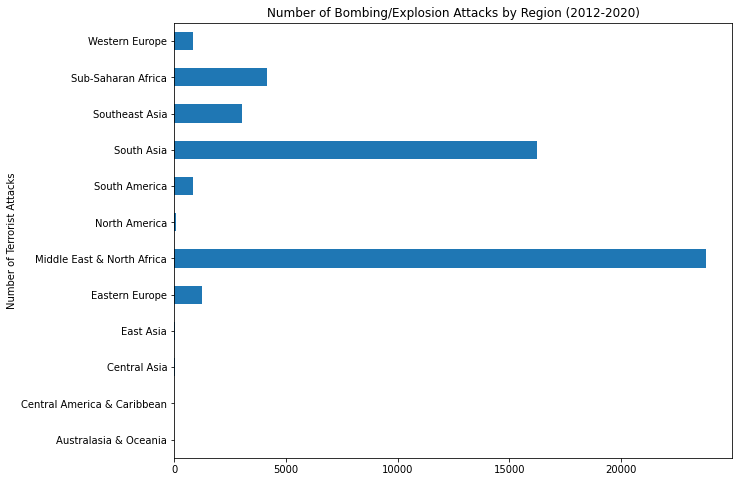

In [31]:
df_3[(df_3["year"].between(2012, 2020)) & (df_3["attack_type"] == "Bombing/Explosion")].groupby(["region"]).size() \
    .plot.barh(xlabel="Number of Terrorist Attacks", ylabel="Region", 
               title="Number of Bombing/Explosion Attacks by Region (2012-2020)", figsize=(10, 8))

Let's investigate further. Which perpetrator groups in Middle East and North Africa caused the most cases of Bombing/Explosion during 2012-2020?

In [32]:
df_3[(df_3["year"].between(2012, 2020)) & (df_3["attack_type"]=="Bombing/Explosion") \
     & (df_3["region"]=="Middle East & North Africa")].groupby("perpetrator")["eventid"].count().\
        reset_index(name="attack_count").nlargest(5,"attack_count",keep="all")

,perpetrator,attack_count
184,Unknown,14045
87,Islamic State of Iraq and the Levant (ISIL),4404
81,Houthi extremists (Ansar Allah),1677
104,Kurdistan Workers' Party (PKK),664
27,Al-Qaida in the Arabian Peninsula (AQAP),366


In [33]:
# top 3 popular methods of attack by year, 1990–2021
most_popular_type_by_year_top3=df_3.groupby(["year","attack_type"]).size().groupby(
level=0).nlargest(3).reset_index(level=0,drop=True)
most_popular_type_by_year_top3

year  attack_type      
1990  Bombing/Explosion    1731
      Assassination         877
      Armed Assault         875
1991  Bombing/Explosion    1988
      Armed Assault        1273
                           ... 
2020  Armed Assault        2112
      Unknown              1349
2021  Bombing/Explosion    1828
      Armed Assault        1292
      Unknown               603
Length: 93, dtype: int64

In [34]:
#Total number of terrorist activities by method from 1990 to 2021
total_methods_of_attacks = df_3.groupby("attack_type")["eventid"].count().sort_values(ascending=False).reset_index(name="attack_count")
total_methods_of_attacks

,attack_type,attack_count
0,Bombing/Explosion,81532
1,Armed Assault,41719
2,Assassination,14826
3,Hostage Taking (Kidnapping),12839
4,Unknown,10275
5,Facility/Infrastructure Attack,9949
6,Unarmed Assault,1188
7,Hostage Taking (Barricade Incident),669
8,Hijacking,600


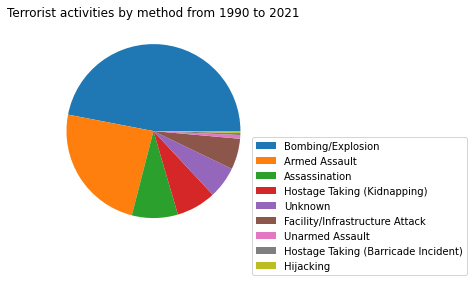

In [35]:
#visualize the size difference 
mylabels = total_methods_of_attacks["attack_type"].tolist()

pie = plt.pie(total_methods_of_attacks["attack_count"])
plt.legend(labels=mylabels, bbox_to_anchor=(1.25,0.5), loc="upper right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.title("Terrorist activities by method from 1990 to 2021")

plt.show()

In [36]:
# most common method of attack by region
most_popular_type_by_region = df_3.groupby(["region", "attack_type"]) \
                                  .size().groupby(level=0).nlargest(1).reset_index(level=0, drop=True)
most_popular_type_by_region

region                       attack_type                   
Australasia & Oceania        Facility/Infrastructure Attack       99
Central America & Caribbean  Bombing/Explosion                   730
Central Asia                 Bombing/Explosion                   237
East Asia                    Bombing/Explosion                   279
Eastern Europe               Bombing/Explosion                  2791
Middle East & North Africa   Bombing/Explosion                 33583
North America                Facility/Infrastructure Attack      618
South America                Bombing/Explosion                  4218
South Asia                   Bombing/Explosion                 24530
Southeast Asia               Bombing/Explosion                  5151
Sub-Saharan Africa           Armed Assault                      8649
Western Europe               Bombing/Explosion                  3941
dtype: int64

#### Conclusion: 
The analysis of terrorist methods across regions and over time reveals insights into global terrorism trends. Bombing/Explosion emerges as the most common method across years since the 70s, especially prevalent in regions such as the Middle East, North Africa, and South Asia. However, there are exceptions, with Facility/Infrastructure Attacks being more common in Australasia & Oceania and North America.

### 4.Plot the locations of attacks on a map to visualize their regional spread

In [37]:
# recall that there are about 1.46% of the data does not have longitude and latitude information. 
df_4 = df[["eventid","longitude","latitude"]]
df_4 = df_4.dropna(subset=["longitude","latitude"])
df_4.head(5)

,eventid,longitude,latitude
0,199001000001,35.503513,33.888523
1,199001010001,74.789902,34.083740
2,199001010002,74.789902,34.083740
3,199001010003,74.789902,34.083740
4,199001010004,-66.166439,-17.382789


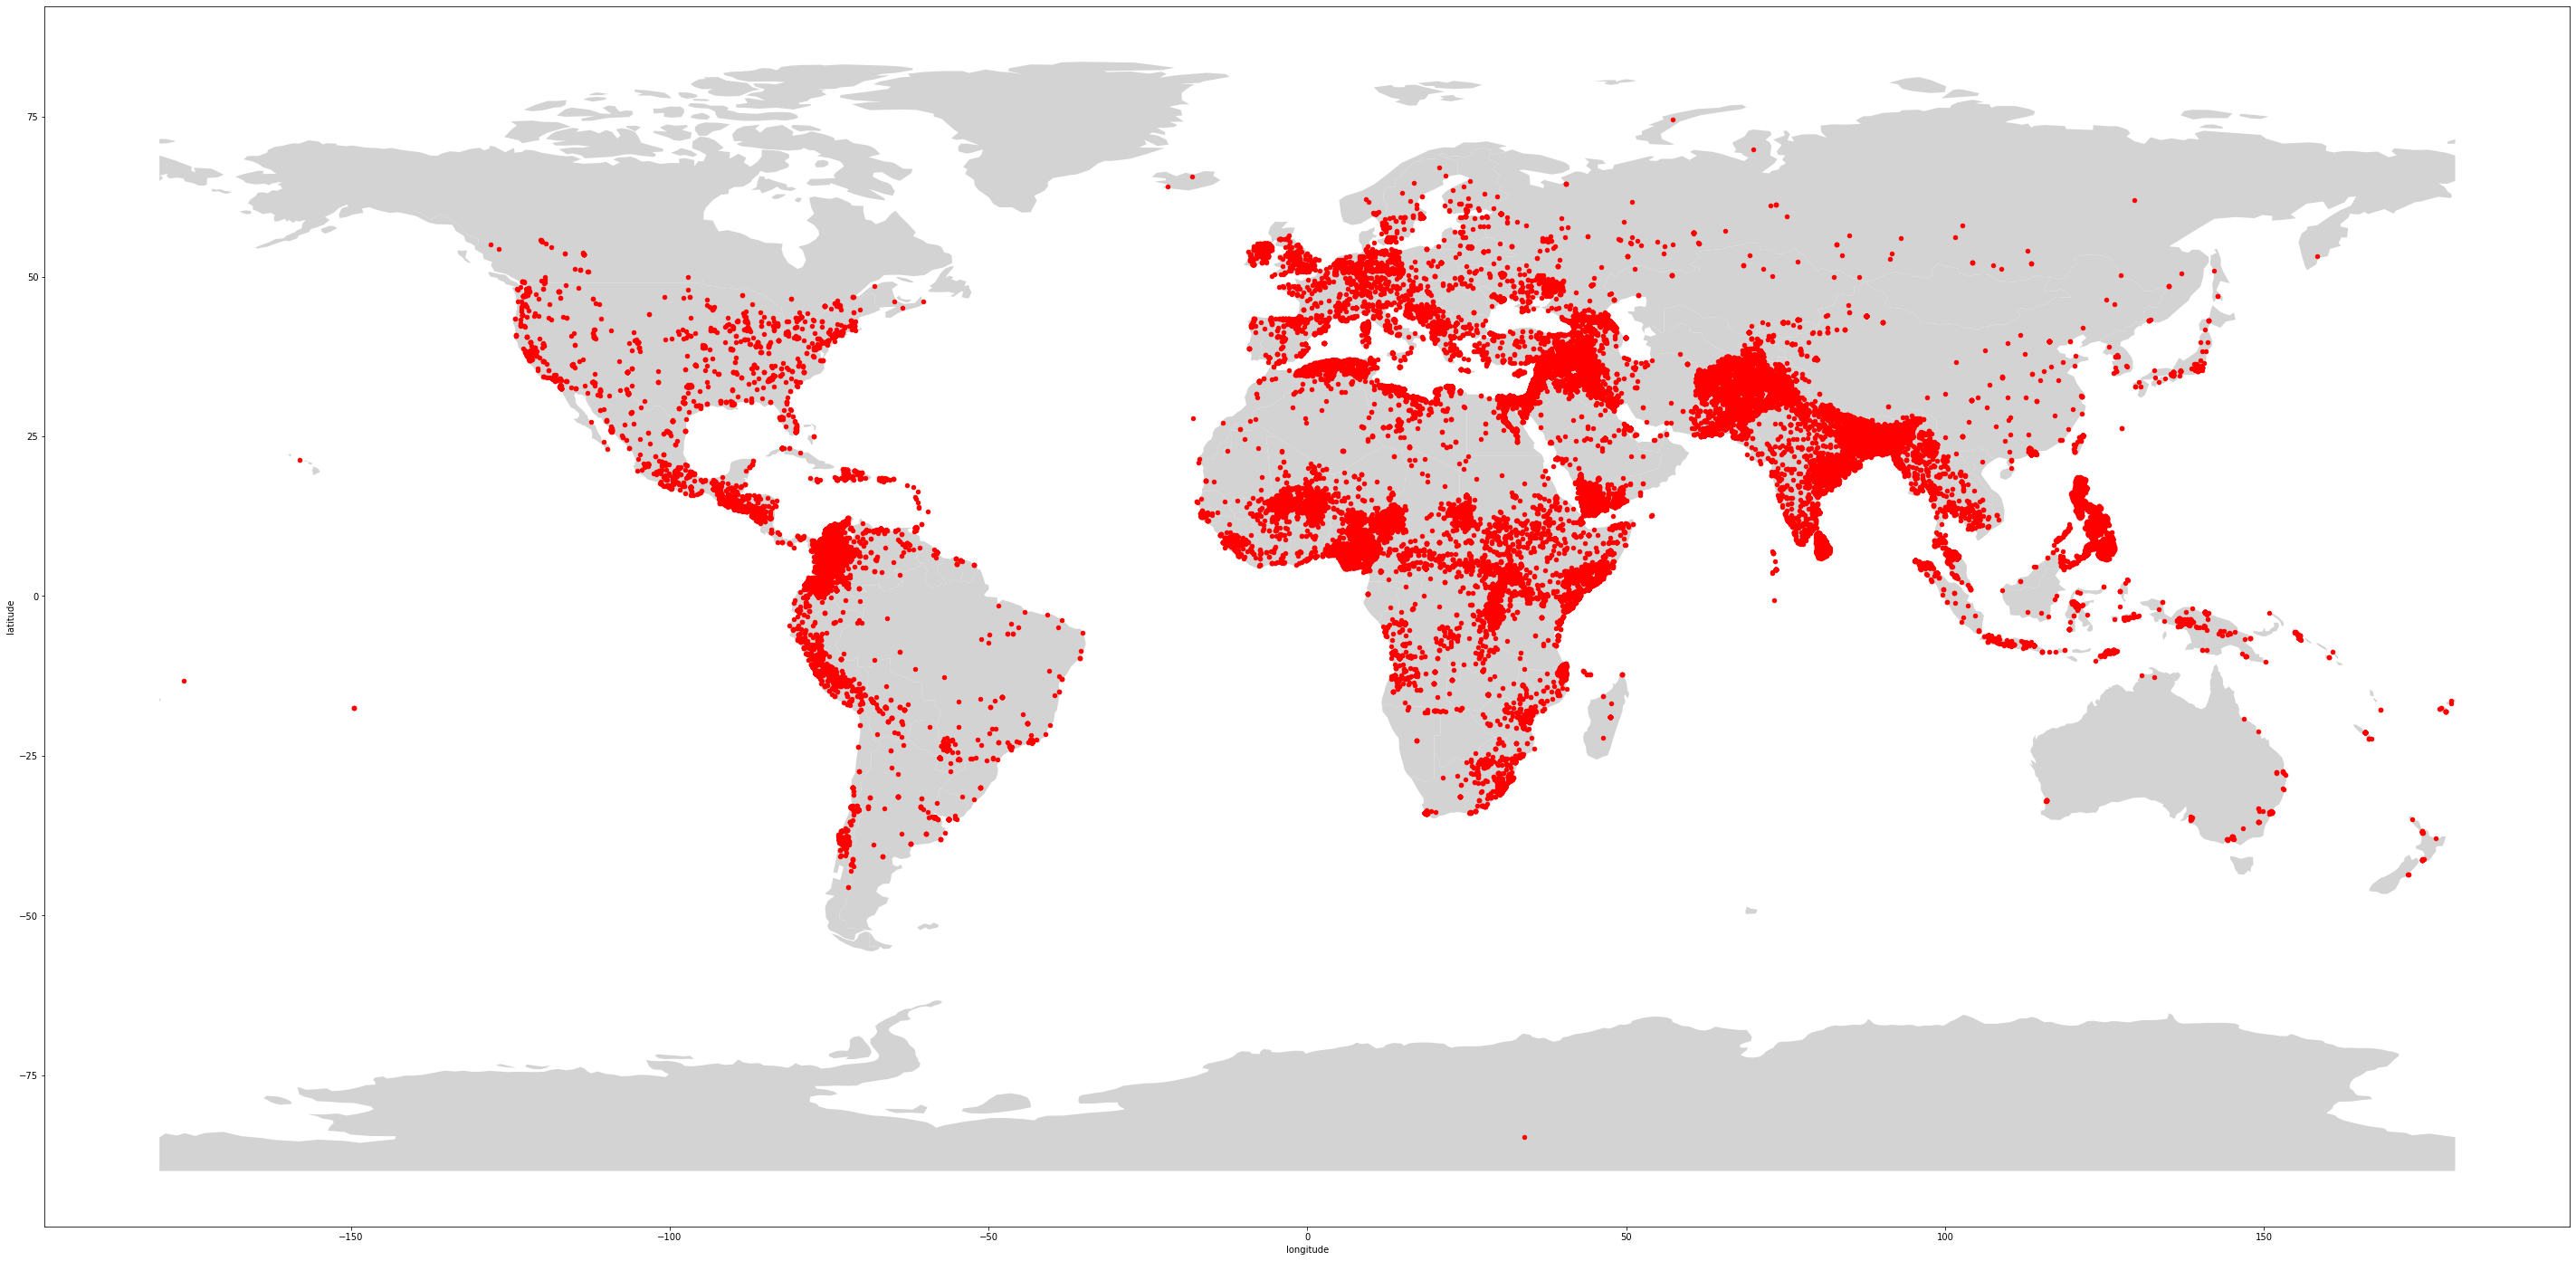

In [38]:
fig, ax = plt.subplots(figsize=(50,25))

countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

df_4.plot(x="longitude", y="latitude", kind="scatter",ax=ax,color="red")
plt.show()

#### Suggestions for Future Research

After this project, I have two ideas for further data analysis:

1) Sentiment analysis of news articles or social media posts about terrorism could show how people feel about it. This might help us understand terrorism better.
<br>2) Additionally, combining different datasets in the field of economics or politics could help us understand terrorism better. (This idea was inspired by Problem 21 of the Practice Final Exam, 'The Legacy of Redlining,' which discovered correlations between geographic information on neighborhoods, housing prices, and temperature.)

Fin! Thank you for your time.
<br>Good luck on your exams, everyone! Keep up the great work!